## Import Libraries

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
palette = sns.color_palette("husl")

## Read Raw Data

In [34]:
df = pd.read_csv("loan_approval_dataset.csv")

In [4]:
df

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4264,4265,5,Graduate,Yes,1000000,2300000,12,317,2800000,500000,3300000,800000,Rejected
4265,4266,0,Not Graduate,Yes,3300000,11300000,20,559,4200000,2900000,11000000,1900000,Approved
4266,4267,2,Not Graduate,No,6500000,23900000,18,457,1200000,12400000,18100000,7300000,Rejected
4267,4268,1,Not Graduate,No,4100000,12800000,8,780,8200000,700000,14100000,5800000,Approved


## Preprocess for EDA

In [35]:
df.drop(df.columns[[0]], axis=1, inplace=True)
new_names = {}

for name in list(df):
  new_names[name] = name.lstrip()
df.rename(columns=new_names, inplace=True)
df['education'] = df['education'].str.lstrip()
df['loan_status'] = df['loan_status'].str.lstrip()
df['self_employed'] = df['self_employed'].str.lstrip()

## EDA

### Check If there are any null values

In [36]:
df.isnull().any()

no_of_dependents            False
education                   False
self_employed               False
income_annum                False
loan_amount                 False
loan_term                   False
cibil_score                 False
residential_assets_value    False
commercial_assets_value     False
luxury_assets_value         False
bank_asset_value            False
loan_status                 False
dtype: bool

### Plot histograms for every categorical variable in our dataset

['Graduate' 'Not Graduate']


<ipython-input-38-8d6e0ccb6ec2>:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data = df, x = 'education', palette = palette)


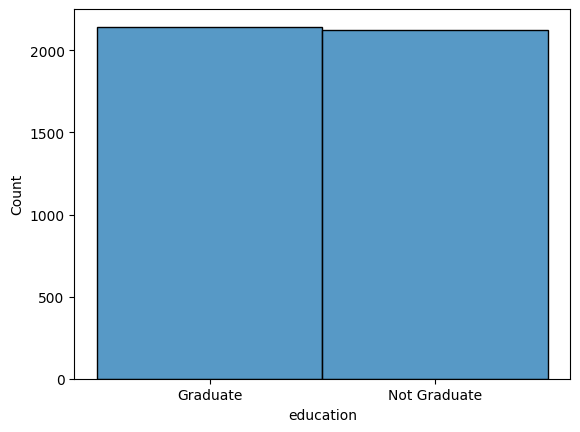

In [38]:
print(df['education'].unique())
sns.histplot(data = df, x = 'education', palette = palette)
plt.show()

['No' 'Yes']


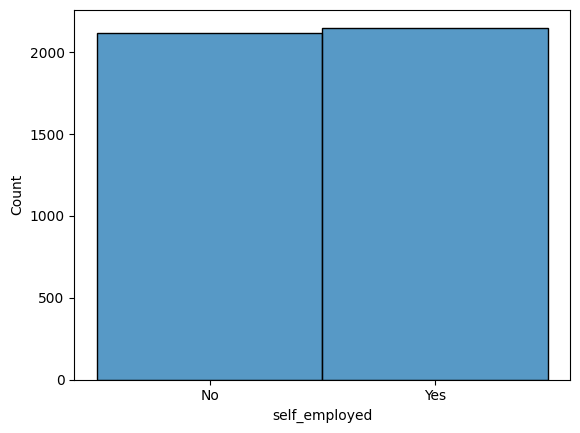

In [43]:
print(df['self_employed'].unique())
sns.histplot(data = df, x = 'self_employed')
plt.show()

**As we can see from the following histogram the dataset is imbalanced. Approved loans are almost twice as large as rejected loans, that may increase bias error to our model. We will check it later how to deal with this problem and if it affects our generalisation error.**

['Approved' 'Rejected']


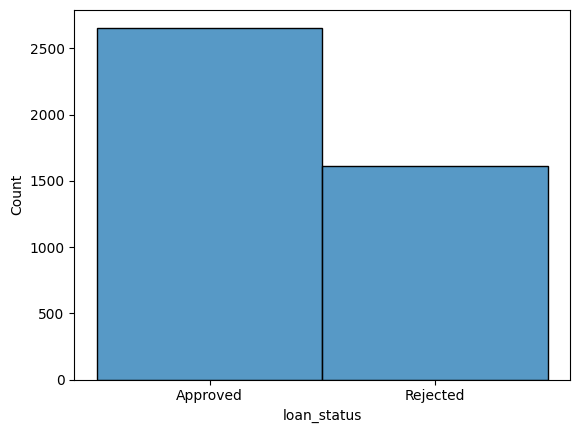

In [67]:
print(df['loan_status'].unique())
sns.histplot(data = df, x = 'loan_status')
plt.show()

### Check for outliers

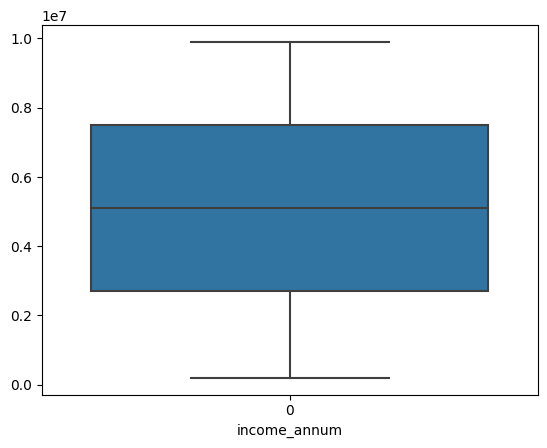

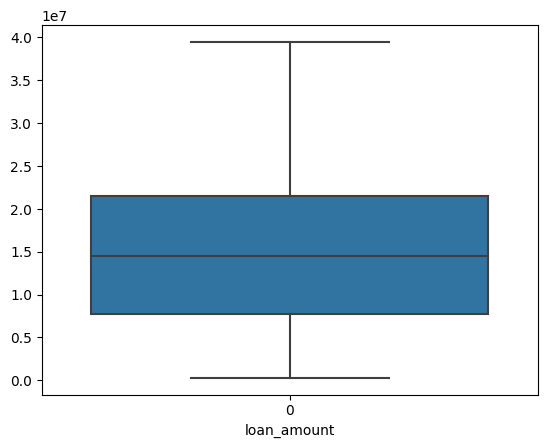

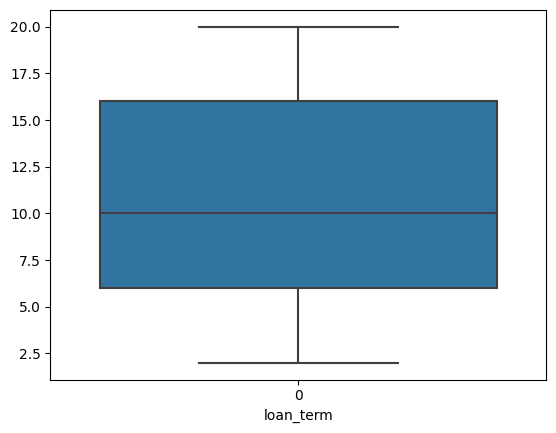

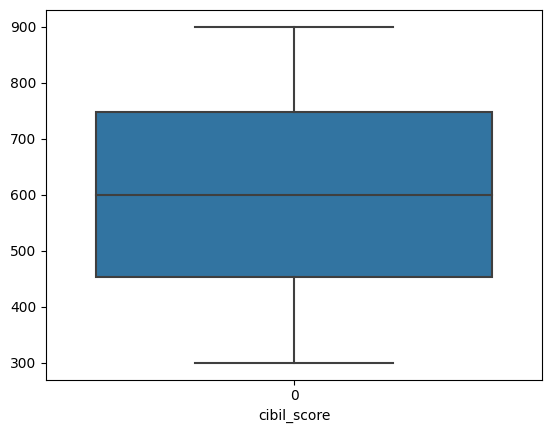

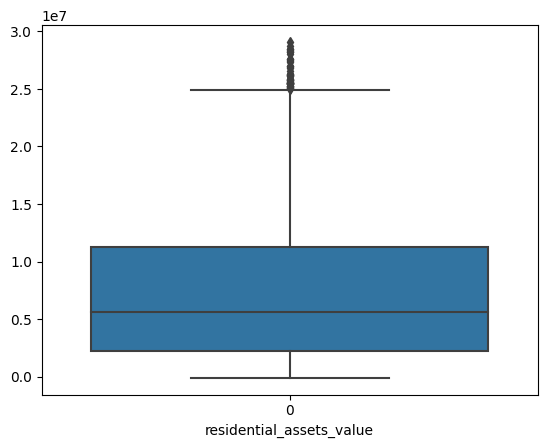

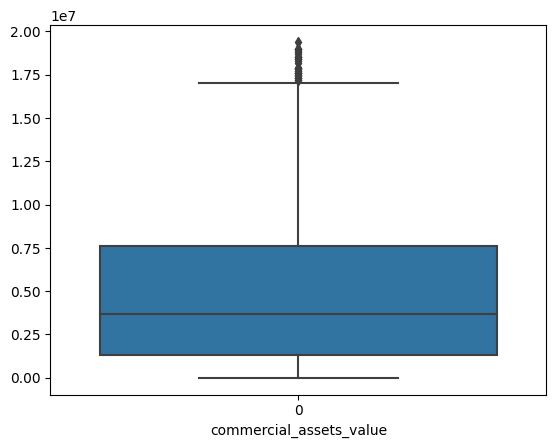

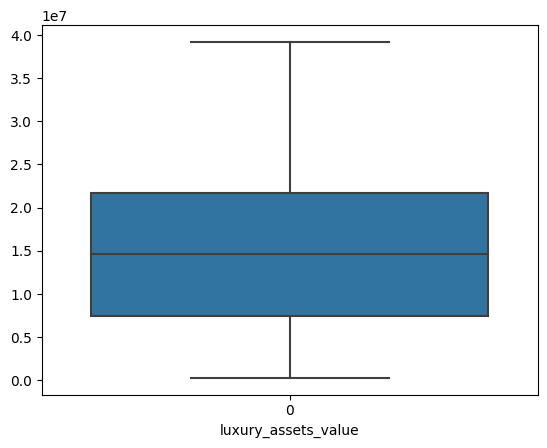

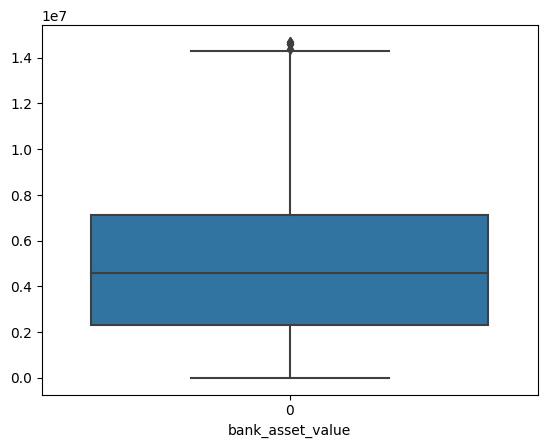

In [54]:
for i in range (3, len(df.columns)-1):
  sns.boxplot(data=df.iloc[:,i])
  plt.xlabel(df.columns[i])
  plt.show()

Residential Assets Values and Commercial Assets Value had some outliers. Let's check them.

How many are outliers: 51


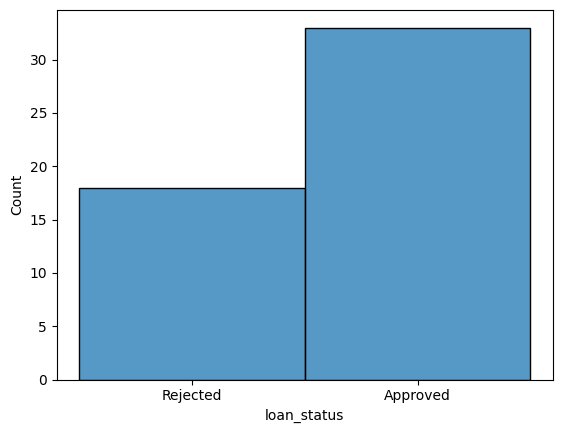

In [70]:
count = (df['residential_assets_value'] > 25000000).sum()
print(f"How many are outliers: {count}")
filtered_df = df[df['residential_assets_value'] > 25000000]
result = filtered_df[['loan_status', 'residential_assets_value']]
sns.histplot(data = result, x = 'loan_status')
plt.show()

How many are outliers: 37


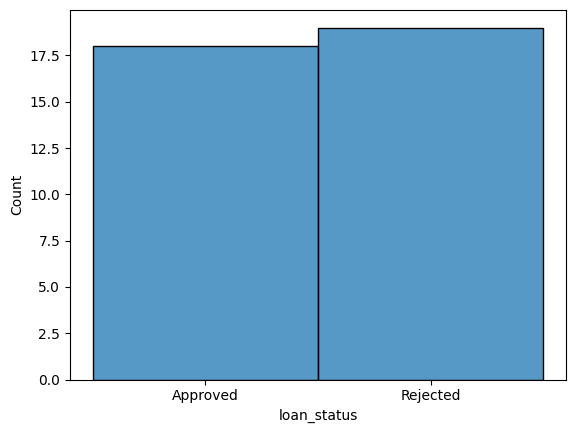

In [71]:
count = (df['commercial_assets_value'] > 17000000).sum()
print(f"How many are outliers: {count}")
filtered_df = df[df['commercial_assets_value'] > 17000000]
result = filtered_df[['loan_status', 'commercial_assets_value']]
sns.histplot(data = result, x = 'loan_status')
plt.show()

My decision is not to delete those outliers, they might affect normalisation of the data but they are not noise, the model needs values to have a point of reference to that input subspace

### Let's encode all categorical values using LabelEncoder from scikit-learn library.

In [39]:
le_education = LabelEncoder()
le_education.fit(df['education'])

for i,element in enumerate(le_education.classes_):
  print(f"{element} -> {i}")
df['education'] = le_education.transform(df['education'])
le_self_employed = LabelEncoder()
le_self_employed.fit(df['self_employed'])

for i,element in enumerate(le_self_employed.classes_):
  print(f"{element} -> {i}")
df['self_employed'] = le_self_employed.transform(df['self_employed'])
le_loan_status = LabelEncoder()
le_loan_status.fit(df['loan_status'])

for i,element in enumerate(le_loan_status.classes_):
  print(f"{element} -> {i}")
df['loan_status'] = le_loan_status.transform(df['loan_status'])

Graduate -> 0
Not Graduate -> 1
No -> 0
Yes -> 1
Approved -> 0
Rejected -> 1


### Splitting before make any changes and our test set has some information about the test set. Here we make the assumption that the sample distribution for the loan_status is the same as the population distribution. Thus, we will use stratify, so the test set to has the same distribution as the sample dataset. We split 80% train 20%test

In [40]:
X, y = df.iloc[:, :-1].values, df.iloc[:, -1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

### Now we will standardize every set for every variable to be in the same scale.

In [48]:
sc_train = StandardScaler()
sc_test = StandardScaler()
X_train_std = sc_train.fit_transform(X_train)
X_test_std = sc_test.fit_transform(X_test)

### Use PCA to undestand the variance of the features and see if we can project the input space into a less dimensional space.

In [42]:
cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in eigen_vals]

pca_variance_dict = {}
for i,column in enumerate(df.columns[:-1]):
  pca_variance_dict[column] = var_exp[i]

pca_variance_dict = dict(sorted(pca_variance_dict.items(), key=lambda item: item[1], reverse = True))

In [43]:
pca_variance_dict

{'no_of_dependents': 0.40810079664540594,
 'luxury_assets_value': 0.09441600080283943,
 'bank_asset_value': 0.09351593616259574,
 'commercial_assets_value': 0.09131963351664671,
 'residential_assets_value': 0.0896526568071928,
 'cibil_score': 0.08592537310263916,
 'loan_term': 0.05259414263787098,
 'loan_amount': 0.04590109748111793,
 'income_annum': 0.022129137306268226,
 'self_employed': 0.012514290078327902,
 'education': 0.003930935459095301}

In [29]:
cross_dependents = pd.crosstab(index=df['no_of_dependents'], columns=df['loan_status'])
cross_dependents['Approved_percentage'] = (cross_dependents[0]/(cross_dependents[0] + cross_dependents[1])) * 100
cross_dependents['Rejected_percentage'] = (cross_dependents[1]/(cross_dependents[0] + cross_dependents[1])) * 100

In [30]:
cross_dependents

loan_status,0,1,Approved_percentage,Rejected_percentage
no_of_dependents,,,,
0,457,255,64.185393,35.814607
1,430,267,61.692970,38.307030
2,441,267,62.288136,37.711864
3,457,270,62.861073,37.138927
4,465,287,61.835106,38.164894
5,406,267,60.326895,39.673105


<ipython-input-32-1367a7b9da98>:4: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  sns.lineplot(data=cross_dependents, dashes=False, markers="o", palette=palette)
<ipython-input-32-1367a7b9da98>:4: UserWarning: 
The markers list has fewer values (1) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data=cross_dependents, dashes=False, markers="o", palette=palette)


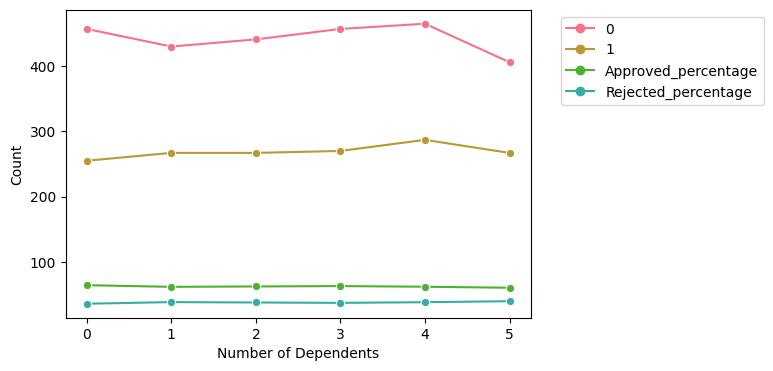

In [32]:
plt.figure(figsize = (6,4))
sns.lineplot(data=cross_dependents, dashes=False, markers="o", palette=palette)
plt.ylabel("Count")
plt.xlabel("Number of Dependents")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

As we can see, the number of dependents does not affect the approved or rejected percentage, so we can say that it does not affect the loan status.

In [ ]:
df.drop(df[['education', 'no_of_dependents', 'self_employed']], axis=1, inplace=True)
df.to_csv("drive/MyDrive/bank-loan-prediction/loan_approval_dataset_preprocessed.csv",index=False)

## Model Train Evaluate

In [117]:
df = pd.read_csv("loan_approval_dataset_preprocessed.csv")

,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,9600000,29900000,12,778,2400000,17600000,22700000,8000000,0
1,4100000,12200000,8,417,2700000,2200000,8800000,3300000,1
2,9100000,29700000,20,506,7100000,4500000,33300000,12800000,1
3,8200000,30700000,8,467,18200000,3300000,23300000,7900000,1
4,9800000,24200000,20,382,12400000,8200000,29400000,5000000,1
...,...,...,...,...,...,...,...,...,...
4264,1000000,2300000,12,317,2800000,500000,3300000,800000,1
4265,3300000,11300000,20,559,4200000,2900000,11000000,1900000,0
4266,6500000,23900000,18,457,1200000,12400000,18100000,7300000,1
4267,4100000,12800000,8,780,8200000,700000,14100000,5800000,0


In [118]:
X, y = df.iloc[:, :-1].values, df.iloc[:, -1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)
sc_train = StandardScaler()
sc_test = StandardScaler()
X_train_std = sc_train.fit_transform(X_train)
X_test_std = sc_test.fit_transform(X_test)

In [60]:
knn = KNeighborsClassifier(n_jobs = -1)
params = {'n_neighbors': [3, 5, 7, 9, 11],
         'weights': ['uniform', 'distance']}
gs_knn = GridSearchCV(knn, param_grid=params, scoring='accuracy', cv=5)

gs_knn.fit(X_train_std, y_train)
print(gs_knn.best_params_)
print(gs_knn.score(X_train_std, y_train))

{'n_neighbors': 9, 'weights': 'distance'}
1.0


In [83]:
knn_model = KNeighborsClassifier(n_neighbors=9, weights ='distance', n_jobs = -1)
knn_model.fit(X_train_std, y_train)
y_hat = knn_model.predict(X_test_std)
print(f"Accuracy: {accuracy_score(y_test, y_hat)}")
print(f"Precision: {precision_score(y_test, y_hat)}")
print(f"Recall: {recall_score(y_test, y_hat)}")
print(f"F1-score: {f1_score(y_test, y_hat)}")
print(f"Confusion Matrix: \n {confusion_matrix(y_test, y_hat)}")

Accuracy: 0.9402810304449649
Precision: 0.9358974358974359
Recall: 0.9040247678018576
F1-score: 0.9196850393700788
Confusion Matrix: 
 [[511  20]
 [ 31 292]]


In [79]:
ct = DecisionTreeClassifier()
params = {
    "criterion" : ['entropy', 'gini'],
    "max_depth" : [5,6,7,8,9,10,11,12,13,14,15],
    'ccp_alpha': [0.1, .01, .001],
    'max_features': ['sqrt', 'log2']
}
gs_ct = GridSearchCV(ct, param_grid=params, scoring='accuracy', cv=5)
gs_ct.fit(X_train_std, y_train)
print(gs_ct.best_params_)
print(gs_ct.score(X_train_std, y_train))

{'ccp_alpha': 0.001, 'criterion': 'entropy', 'max_depth': 13, 'max_features': 'log2'}
0.9874084919472914


In [95]:
ct_model = DecisionTreeClassifier( ccp_alpha = 0.001, criterion ='entropy', max_depth = 13, max_features = 'log2', random_state = 2)
ct_model.fit(X_train_std, y_train)
y_hat = ct_model.predict(X_test_std)
print(f"Accuracy: {accuracy_score(y_test, y_hat)}")
print(f"Precision: {precision_score(y_test, y_hat)}")
print(f"Recall: {recall_score(y_test, y_hat)}")
print(f"F1-score: {f1_score(y_test, y_hat)}")
print(f"Confusion Matrix: \n {confusion_matrix(y_test, y_hat)}")

Accuracy: 0.9707259953161592
Precision: 0.9542682926829268
Recall: 0.9690402476780186
F1-score: 0.9615975422427034
Confusion Matrix: 
 [[516  15]
 [ 10 313]]


In [114]:
sc= StandardScaler()
X_std = sc.fit_transform(X)
ct_model = DecisionTreeClassifier( ccp_alpha = 0.001, criterion ='entropy', max_depth = 13, max_features = 'log2', random_state = 2)
ct_model.fit(X_std, y)

feature_importance_dict = {}
for i,column in enumerate(df.columns[:-1]):
  feature_importance_dict[column] = ct_model.feature_importances_[i]

feature_importance_dict = dict(sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse = True))
feature_importance_dict

{'cibil_score': 0.8059966451532563,
 'loan_term': 0.12686584185671404,
 'loan_amount': 0.021506162550100537,
 'commercial_assets_value': 0.01592810247532623,
 'residential_assets_value': 0.007912303120996517,
 'bank_asset_value': 0.007890230818377584,
 'luxury_assets_value': 0.007317510306061794,
 'income_annum': 0.006583203719166939}

## Report

### Best Model

The best model is DecisionTreeClassifier ( ccp_alpha = 0.001, criterion ='entropy', max_depth = 13, max_features = 'log2', random_state = 2) because it surpasses every metric in evaluation of the test set (Accuracy = 0.97, Precision = 0.95, Recall = 0.97, F1-Score = 0.96) the knn model (Accuracy = 0.94, Precision = 0.93, Recall = 0.90, F1-Score = 0.91)

### Most Valuable Features

The most valuable features based on the DecisionTree model are "cibil_score", "loan_term" and "loan_mount"

### Insights

 The fact that cibil_score is one of the most valuable features suggests that the cibil_score plays a significant role in determining the creditworthiness of applicants. The bank can consider setting a minimum credit score requirement to ensure that applicants have a good credit history and are less likely to default on their loans.

Due to the fact that loan_term is the second most valuable feature, the bank can also consider adjusting the loan terms to better align with the needs and financial capabilities of their customers.